## Demonstration of Herbie for easily getting NWP/AIFS/etc. datasets

### Herbie docs: https://herbie.readthedocs.io/en/stable/

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ai_weather_to_climate_ats780A8/tree/main/lecture_code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/ai_weather_to_climate_ats780A8/blob/main/lecture_code/herbie_examples.ipynb)

In [ ]:
!pip install herbie-data cartopy

In [1]:
from herbie import Herbie

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### these are plotting functions built in to Herbie, they are optional to use here
from herbie import paint
from herbie.toolbox import EasyMap, pc

### get AIFS forecast grids

In [2]:
init = pd.Timestamp(2024,10,16,0)

fxx = 72  ### start with th 72-h forecast as an example

H_aifs = Herbie(init.strftime("%Y-%m-%d %H:%M"), model="aifs", product="oper", fxx=fxx)  

✅ Found ┊ model=aifs ┊ product=oper ┊ 2024-Oct-16 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws


#### you can look at the full inventory this way, though it's a little cumbersome

In [3]:
H_aifs.inventory()

,grib_message,start_byte,end_byte,range,reference_time,valid_time,step,param,levelist,levtype,number,domain,expver,class,type,stream,search_this
0,1,0,1038052,0-1038052,2024-10-16,2024-10-19,3 days,z,925,pl,NaN,g,0001,ai,fc,oper,:z:925:pl:g:0001:ai:fc:oper
1,2,1038052,1906107,1038052-1906107,2024-10-16,2024-10-19,3 days,z,200,pl,NaN,g,0001,ai,fc,oper,:z:200:pl:g:0001:ai:fc:oper
2,3,1906107,3048514,1906107-3048514,2024-10-16,2024-10-19,3 days,w,925,pl,NaN,g,0001,ai,fc,oper,:w:925:pl:g:0001:ai:fc:oper
3,4,3048514,3683088,3048514-3683088,2024-10-16,2024-10-19,3 days,v,200,pl,NaN,g,0001,ai,fc,oper,:v:200:pl:g:0001:ai:fc:oper
4,5,3683088,4371723,3683088-4371723,2024-10-16,2024-10-19,3 days,10u,NaN,sfc,NaN,g,0001,ai,fc,oper,:10u:sfc:g:0001:ai:fc:oper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,59049379,59711566,59049379-59711566,2024-10-16,2024-10-19,3 days,q,700,pl,NaN,g,0001,ai,fc,oper,:q:700:pl:g:0001:ai:fc:oper
84,85,59711566,60396165,59711566-60396165,2024-10-16,2024-10-19,3 days,v,300,pl,NaN,g,0001,ai,fc,oper,:v:300:pl:g:0001:ai:fc:oper
85,86,60396165,60964929,60396165-60964929,2024-10-16,2024-10-19,3 days,q,250,pl,NaN,g,0001,ai,fc,oper,:q:250:pl:g:0001:ai:fc:oper
86,87,60964929,61610160,60964929-61610160,2024-10-16,2024-10-19,3 days,v,100,pl,NaN,g,0001,ai,fc,oper,:v:100:pl:g:0001:ai:fc:oper


#### better if you have an idea of what level or variable you want to look at:

In [4]:
H_aifs.inventory(":z:500")

,grib_message,start_byte,end_byte,range,reference_time,valid_time,step,param,levelist,levtype,number,domain,expver,class,type,stream,search_this
6,7,5266518,6203174,5266518-6203174,2024-10-16,2024-10-19,3 days,z,500,pl,NaN,g,0001,ai,fc,oper,:z:500:pl:g:0001:ai:fc:oper


### if you want to make a really quick map, the built-in functions in Herbie make that really easy. This reads the data into xarray, and plots it

#### this will temporarily download the needed file to $HOME/data/aifs, and then delete it. If you don't want it deleted, you can add "remove_grib=False" when calling xarray below

<xarray.Dataset> Size: 4MB
Dimensions:              (latitude: 721, longitude: 1440)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-16
    step                 timedelta64[ns] 8B 3 days
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           datetime64[ns] 8B 2024-10-19
    gribfile_projection  object 8B None
Data variables:
    z                    (latitude, longitude) float32 4MB 5.108e+04 ... 4.92...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   aifs
    product:                 oper
    description:             ECMWF Open Data - Artificial Inteligence Integra...
    remote_grib:             https://ecmwf-forecasts.s3.eu-central-1.amazonaw...
    local_grib:              /Users/rschumac/data/aifs/20241016/subset_ebf168...
    search:                  :z:500

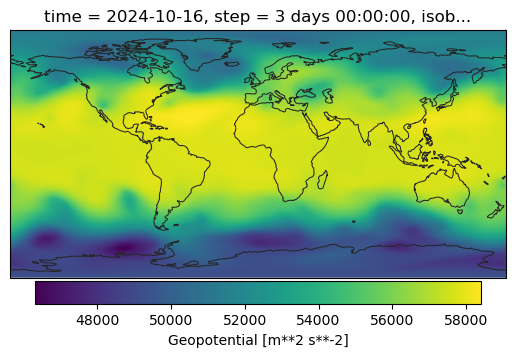

In [5]:
ds_aifs = H_aifs.xarray(":z:500")  
ds_aifs.z.plot(
    x="longitude",
    y="latitude",
    ax=EasyMap().ax,
    transform=pc,
    cbar_kwargs=dict(orientation="horizontal", shrink=0.9, pad=0.01))

ds_aifs

### turns out that the AIFS output is in geopotential rather than geopotential height. we'll fix that and make a plot more traditionally over North America

In [6]:
datacrs = ccrs.PlateCarree()

plotcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=37.5)

def plot_background(ax):
     ### set up bounding box surrounding specified station
    latmin=27.75
    latmax=48.25
    lonmin=-118.7
    lonmax=-83.75

    ax.set_extent([lonmin,lonmax,latmin,latmax])
    ax.coastlines('50m', edgecolor='black', linewidth=0.9)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.2)

    return lonmin,lonmax,latmin,latmax

lead 72, valid 2024-10-19 00:00:00


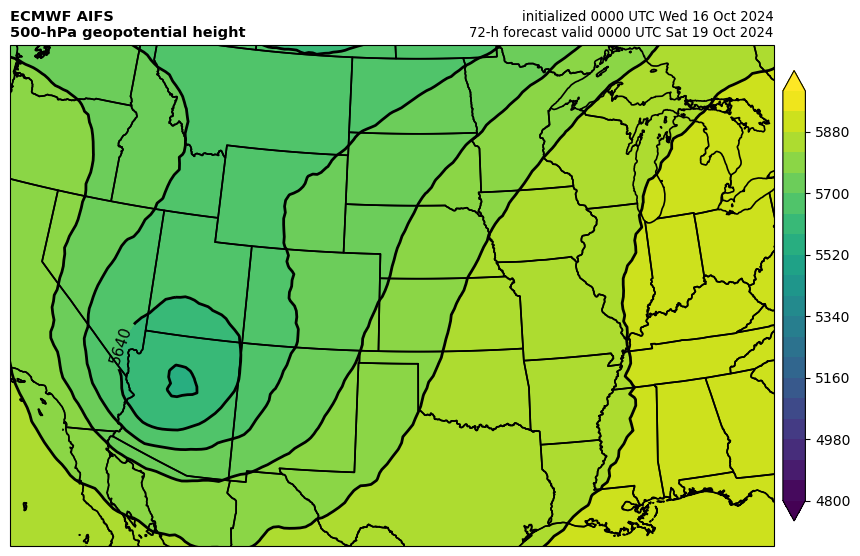

In [7]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(1,1,1,projection=plotcrs)

lonmin, lonmax, latmin, latmax = plot_background(ax)

vtime = pd.to_datetime(ds_aifs.valid_time.values)
step = ds_aifs.step

fcst_lead = int((vtime - init) / pd.Timedelta('1 hour'))

print("lead "+str(fcst_lead)+", valid "+str(vtime))

lon2d, lat2d = np.meshgrid(ds_aifs.longitude,ds_aifs.latitude)

### height
cf = ax.contourf(lon2d, lat2d,
                 ds_aifs.z/9.80665,  ### convert to meters
                    np.arange(4800, 6060, 60), extend='both',
                 transform=ccrs.PlateCarree(),
                     transform_first=True)
cb = plt.colorbar(cf, shrink=0.9, pad=0.01)

cs1 = ax.contour(lon2d, lat2d,
                 ds_aifs.z/9.80665,
                    np.arange(4800, 6060, 60), colors='black',
                     linewidths=2, transform=ccrs.PlateCarree(),
                     transform_first=True)
plt.clabel(cs1, fontsize=11, inline=True, inline_spacing=5, fmt='%i',
                    rightside_up=True, use_clabeltext=True)

ax.set_title("ECMWF AIFS\n500-hPa geopotential height",
              loc="left", horizontalalignment='left', fontsize=10.5, fontweight='bold')
ax.set_title("initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+vtime.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=9.5)

plt.show()

plt.close('all')

### now we could also easily get the IFS forecast valid at the same time, and see how they differ

In [8]:
H_ifs = Herbie(init.strftime("%Y-%m-%d %H:%M"), model="ifs", product="oper", fxx=fxx)  

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Oct-16 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws


#### unlike AIFS, the IFS gives geopotential height rather than geopotential

In [9]:
ds_ifs = H_ifs.xarray(":gh:500")
ds_ifs

<xarray.Dataset> Size: 4MB
Dimensions:              (latitude: 721, longitude: 1440)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-16
    step                 timedelta64[ns] 8B 3 days
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           datetime64[ns] 8B 2024-10-19
    gribfile_projection  object 8B None
Data variables:
    gh                   (latitude, longitude) float32 4MB 5.213e+03 ... 5.05...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    model:                   ifs
    product:                 oper
    description:             ECMWF Open Data - Integrated Forecast System
    remote_grib:             https://ecmwf-forecasts.s3.eu-central-1.amazonaw...
    local_grib:              /Users/rschumac/data/ifs/20241016/subset_ebf158c...
    search:                  :gh:500

### plot map

lead 72, valid 2024-10-19 00:00:00


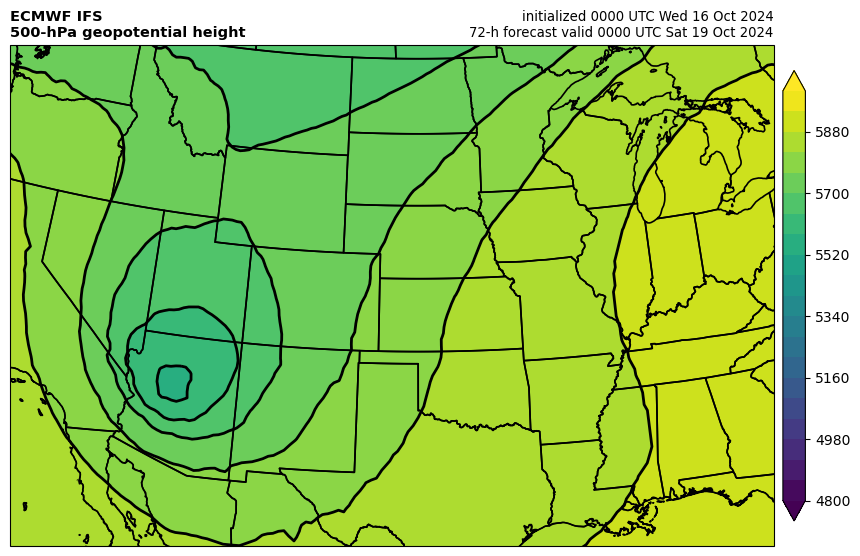

In [10]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(1,1,1,projection=plotcrs)

lonmin, lonmax, latmin, latmax = plot_background(ax)

vtime = pd.to_datetime(ds_ifs.valid_time.values)
step = ds_ifs.step

fcst_lead = int((vtime - init) / pd.Timedelta('1 hour'))

print("lead "+str(fcst_lead)+", valid "+str(vtime))

lon2d, lat2d = np.meshgrid(ds_ifs.longitude,ds_ifs.latitude)

### height
cf = ax.contourf(lon2d, lat2d,
                 ds_ifs.gh,
                    np.arange(4800, 6060, 60), extend='both',
                 transform=ccrs.PlateCarree(),
                     transform_first=True)
cb = plt.colorbar(cf, shrink=0.9, pad=0.01)

cs1 = ax.contour(lon2d, lat2d,
                 ds_ifs.gh,
                    np.arange(4800, 6060, 60), colors='black',
                     linewidths=2, transform=ccrs.PlateCarree(),
                     transform_first=True)
#plt.clabel(cs1, fontsize=11, inline=True, inline_spacing=5, fmt='%i',
#                    rightside_up=True, use_clabeltext=True)

ax.set_title("ECMWF IFS\n500-hPa geopotential height",
              loc="left", horizontalalignment='left', fontsize=10.5, fontweight='bold')
ax.set_title("initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+vtime.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=9.5)

plt.show()

plt.close('all')

### now let's look at the difference

In [11]:
z500_diff = ds_aifs.z/9.80665 - ds_ifs.gh

z500_diff

<xarray.DataArray (latitude: 721, longitude: 1440)> Size: 4MB
array([[ -4.129883,  -4.129883,  -4.129883, ...,  -4.129883,  -4.129883,
         -4.129883],
       [-12.532227, -12.532227, -12.557617, ..., -12.480957, -12.506348,
        -12.506348],
       [-13.641602, -13.666992, -13.692383, ..., -13.564941, -13.590332,
        -13.616211],
       ...,
       [-29.436035, -29.436035, -29.461426, ..., -29.385254, -29.410645,
        -29.410645],
       [-25.68457 , -25.68457 , -25.68457 , ..., -25.65918 , -25.65918 ,
        -25.65918 ],
       [-26.18457 , -26.18457 , -26.18457 , ..., -26.18457 , -26.18457 ,
        -26.18457 ]], dtype=float32)
Coordinates:
    time                 datetime64[ns] 8B 2024-10-16
    step                 timedelta64[ns] 8B 3 days
    isobaricInhPa        float64 8B 500.0
  * latitude             (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude            (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time           datetime64[ns] 8B 2024-10-19
    gribfile_projection  object 8B None

lead 72, valid 2024-10-19 00:00:00


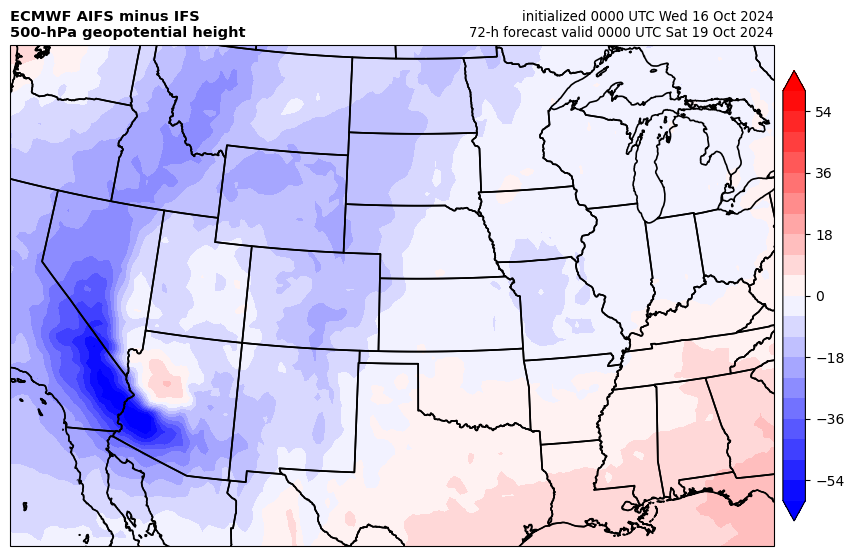

In [12]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(1,1,1,projection=plotcrs)

lonmin, lonmax, latmin, latmax = plot_background(ax)

vtime = pd.to_datetime(z500_diff.valid_time.values)
step = z500_diff.step

fcst_lead = int((vtime - init) / pd.Timedelta('1 hour'))

print("lead "+str(fcst_lead)+", valid "+str(vtime))

lon2d, lat2d = np.meshgrid(z500_diff.longitude,z500_diff.latitude)

### height
cf = ax.contourf(lon2d, lat2d,
                 z500_diff,
                    np.arange(-60,66,6), extend='both',
                 cmap='bwr',
                 transform=ccrs.PlateCarree(),
                     transform_first=True)
cb = plt.colorbar(cf, shrink=0.9, pad=0.01)

ax.set_title("ECMWF AIFS minus IFS\n500-hPa geopotential height",
              loc="left", horizontalalignment='left', fontsize=10.5, fontweight='bold')
ax.set_title("initialized "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+vtime.strftime("%H%M UTC %a %d %b %Y"),
              loc="right", horizontalalignment='right', fontsize=9.5)

plt.show()

plt.close('all')

### you could get just about any model from Herbie this same way, just check the herbie docs for what the "products" are. Ensembles too!

#### NOAA and ECWMF models do have slightly different names for their variables as well

In [23]:
H_gfs = Herbie(init.strftime("%Y-%m-%d %H:%M"), model="gfs", product="pgrb2.0p25", fxx=fxx)  
ds_gfs = H_gfs.xarray(":HGT:500")

#H_nam = Herbie(init.strftime("%Y-%m-%d %H:%M"), model="nam", product="awphys", fxx=fxx)  
#ds_nam = H_nam.xarray(":HGT:500")

### GFS-graphcast
H_gc = Herbie(init.strftime("%Y-%m-%d %H:%M"), model="graphcast", fxx=fxx)  
ds_gc = H_gc.xarray(":HGT:500")


✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-16 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=graphcast ┊ product=pgrb2.0p25 ┊ 2024-Oct-16 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/Users/rschumac/data/graphcast/20241016]


### now make a 4-panel comparing them using subplot_mosaic

ECMWF AIFS
ECMWF IFS
NOAA GFS-Graphcast
NOAA GFS


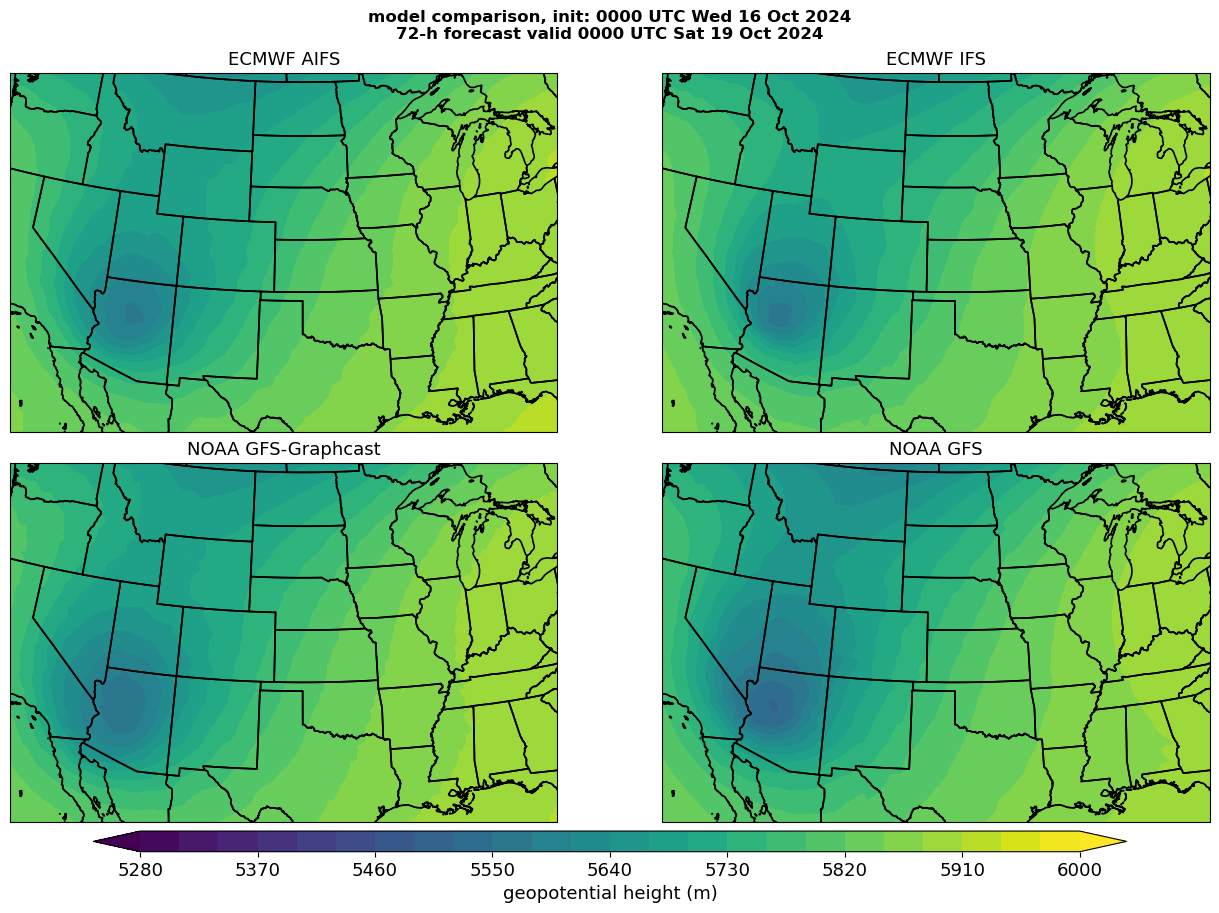

In [35]:
models_to_plot = ['ECMWF AIFS','ECMWF IFS','NOAA GFS-Graphcast','NOAA GFS'] #'NOAA NAM']  

### dictionary connecting those nicer names to the datasets
model_ds_dict = {"ECMWF AIFS":ds_aifs, "ECMWF IFS": ds_ifs,
                 "NOAA GFS": ds_gfs, "NOAA GFS-Graphcast": ds_gc} # "NOAA NAM": ds_nam}

fig = plt.figure(layout="constrained", figsize=(13,9))

axlist=[]
ax_dict = fig.subplot_mosaic(
    [
        models_to_plot[0:2],
        models_to_plot[2:4],
    ],
    subplot_kw={"projection": plotcrs})

for k, ax in ax_dict.items():
    lonmin, lonmax, latmin, latmax = plot_background(ax)
    axlist = axlist + [ax]

### read in data, looping over models
for model in models_to_plot:
    print(model)

    ds_this = model_ds_dict[model]

    clevs = np.arange(5280, 6030, 30)

    ### account for AIFS having z instead of gh
    if model=="ECMWF AIFS": 
        lon2d, lat2d = np.meshgrid(ds_this.longitude, ds_this.latitude)
        cf = ax_dict[model].contourf(lon2d, lat2d, ds_this.z/9.80665,
                                    clevs, extend='both',
                                     transform=ccrs.PlateCarree(),
                                     transform_first=True)
    ### account for NAM grid that's already 2-d
    elif model=="NOAA NAM":  
        cf = ax_dict[model].contourf(ds_this.longitude, ds_this.latitude, ds_this.gh,
                                    clevs, extend='both',
                                     transform=ccrs.PlateCarree(),
                                     transform_first=True)
    else:
        lon2d, lat2d = np.meshgrid(ds_this.longitude, ds_this.latitude)
        cf = ax_dict[model].contourf(lon2d, lat2d, ds_this.gh,
                                    clevs, extend='both',
                                     transform=ccrs.PlateCarree(),
                                     transform_first=True)
        

    ax_dict[model].set_title(model, fontsize=13)

### overall colorbar
cb = plt.colorbar(cf, ax=axlist, orientation='horizontal', pad=0.01,
                  shrink=0.8, aspect=50)
cb.ax.tick_params(labelsize=13)
cb.set_label('geopotential height (m)', fontsize=13)

## suptitle
plt.suptitle("model comparison, init: "+init.strftime("%H%M UTC %a %d %b %Y")+"\n"+str(fcst_lead)+"-h forecast valid "+vtime.strftime("%H%M UTC %a %d %b %Y"),
            fontweight='semibold')

plt.show()



### now what gets really cool is FastHerbie, which uses multiprocessing to get lots of files at once (https://herbie.readthedocs.io/en/stable/user_guide/tutorial/fast.html) 

In [ ]:
from herbie import FastHerbie

### get initializations two days apart
DATES = pd.date_range(start="2024-10-14 00:00",
                      periods=2,freq="1d")

# Create a range of forecast lead times
fxx = range(0, 132,6)

In [ ]:
# Make FastHerbie Object.
FH = FastHerbie(DATES, model="ifs", product="oper", fxx=fxx)
FH.objects

In [ ]:
# Get 500-hPa height for all in one dataset!
ds = FH.xarray(":gh:500:", remove_grib=False)


In [ ]:
ds